## Project: AARRR Analysis

### 문제 1. 데이터 로드

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.stats import shapiro

In [301]:
# 2개 sheet 병합
df1 = pd.read_excel('./online_retail_II.xlsx', sheet_name = 'Year 2009-2010')
df2 = pd.read_excel('./online_retail_II.xlsx', sheet_name = 'Year 2010-2011')
df = pd.concat([df1, df2], ignore_index = True)
print(df.shape)
df.head(5)

(1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### 문제 2. 데이터 전처리

In [302]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.dropna(subset = ['Customer ID'])
df.astype({'Customer ID':'int'}).dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID             int32
Country                object
dtype: object

In [303]:
# 중복 제거
df = df.drop_duplicates()

In [304]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,797885.000000,797885,797885.000000,797885.000000
mean,12.602980,2011-01-02 13:17:34.141160704,3.702732,15313.062777
min,-80995.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,2.000000,2010-07-02 09:47:00,1.250000,13964.000000
50%,5.000000,2010-12-02 12:33:00,1.950000,15228.000000
75%,12.000000,2011-07-31 15:50:00,3.750000,16788.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,191.670371,NaN,71.392549,1696.466663


In [305]:
import warnings
warnings.filterwarnings('ignore') 

df['Total'] = df['Quantity'] * df['Price']
df.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0


### 문제 3. 나라별 구매 인원 시각화

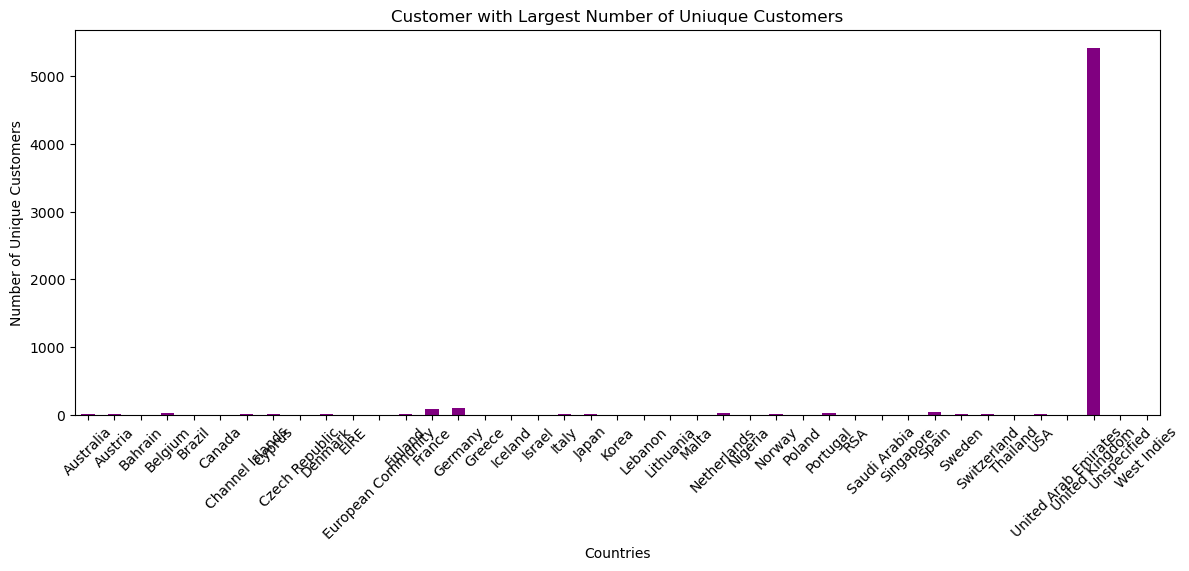

In [306]:
plt.figure(figsize=(14,5))
df.groupby('Country')['Customer ID'].nunique().plot(kind='bar', color='purple')
plt.title('Customer with Largest Number of Uniuque Customers')
plt.xlabel('Countries')
plt.ylabel('Number of Unique Customers')
plt.xticks(rotation=45)
plt.show()
# 그래프 추가 정리하기 LATER

### 문제 4. Acquisition (고객 유입 분석)

- 신규 고객 분석을 위해 고객의 **첫 구매 시점**을 기준으로 월별 신규 유입 고객 수를 계산
- 각 고객의 첫 구매 날짜를 추출하고, **월별 신규 고객 수**를 시각화

In [307]:
df['FirstPurchase'] = df.groupby('Customer ID')['InvoiceDate'].transform('min')

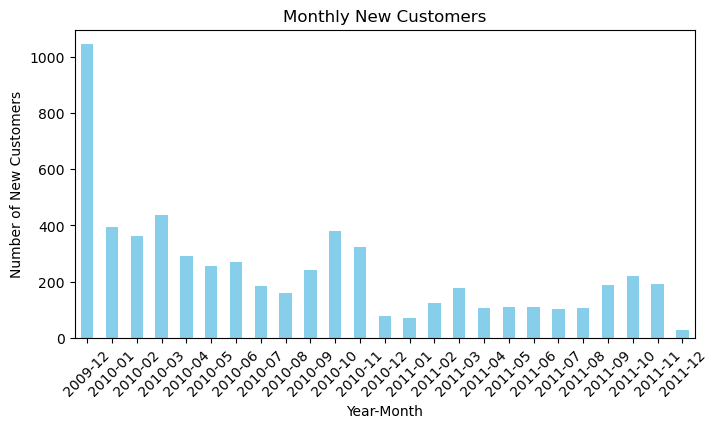

In [308]:
plt.figure(figsize=(8,4))
df.groupby(by=df['FirstPurchase'].dt.to_period('M'))['Customer ID'].nunique().plot(kind='bar', color='skyblue')
plt.title('Monthly New Customers')
plt.xlabel('Year-Month')
plt.ylabel('Number of New Customers')
plt.xticks(rotation=45)
plt.show() 

### 문제 5. Activation (고객 활성화 분석)

- 모든 고객 중 첫 구매 이후 **총 구매 금액이 특정 기준 금액 (£50)** 이상인 고객을 활성화된 고객으로 정의
- 전체 고객 수와 활성화된 고객 수를 비교하여 **활성화율**을 도출

In [309]:
total_users = df['Customer ID'].nunique()
activated_users = (df.groupby('Customer ID')['Total'].sum() >= 50).sum() 
activation_rate = activated_users / total_users
print(f"총 고객 수: {total_users}")
print(f"활성화된 고객 수: {activated_users}")
print(f"고객 활성화율: {activation_rate:.2%}")

총 고객 수: 5942
활성화된 고객 수: 5774
고객 활성화율: 97.17%


### 문제 6. Retention: 코호트 분석(고객)

- 분기별 활성 사용자(MAU)를 분석하여 고객 유지 현황을 파악
- 분기별 활성 고객 수를 계산하고, 이를 시각화하여 **고객 유지 트렌드**를 분석

In [310]:
df['is_activated'] = df.groupby('Customer ID')['Total'].transform('sum') >= 50

In [311]:
df.is_activated.value_counts()


is_activated
True     796745
False      1140
Name: count, dtype: int64

In [312]:
not_activated = df[df['is_activated'] == False].index
dfa = df.copy()
dfa.drop(not_activated, inplace =True)

In [313]:
dfa['current_q'] = pd.to_datetime(dfa['InvoiceDate']).dt.to_period('Q')
dfa['cohort_q'] = dfa.groupby('Customer ID')['current_q'].transform('min')

def q_diff(dfa, col1, col2):
    current = dfa[col1]
    cohort = dfa[col2]
    return (current.dt.year - cohort.dt.year) * 4 + (current.dt.quarter - cohort.dt.quarter)

dfa['quarter_diff'] = q_diff(dfa, 'current_q', 'cohort_q')
dfa.tail(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,FirstPurchase,is_activated,current_q,cohort_q,quarter_diff
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-08-18 15:44:00,True,2011Q4,2011Q3,1
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85,2011-08-18 15:44:00,True,2011Q4,2011Q3,1
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France,18.00,2011-08-18 15:44:00,True,2011Q4,2011Q3,1


In [314]:
cohort_counts = dfa.groupby(['cohort_q', 'quarter_diff'])['Customer ID'].nunique()
cohort_counts_df = cohort_counts.to_frame().rename(columns = {'Customer ID' : 'customers'}).sort_values(by=['cohort_q'])
cohort_counts_df


customers
cohort_q quarter_diff           
2009Q4   0                  1017
         1                   668
         2                   685
         3                   618
         4                   710
         5                   524
         6                   517
         7                   509
         8                   571
2010Q1   7                   407
         6                   444
         5                   430
         4                   416
         0                  1151
         2                   573
         1                   607
         3                   606
2010Q2   4                   245
         6                   244
         3                   182
         5                   227
         1                   324
         0                   788
         2                   348
2010Q3   0                   562
         1                   275
         2                   148
         3                   155
         4                   192
         5                   188
2010Q4   4                   274
         3                   162
         2                   195
         0                   755
         1                   166
2011Q1   0                   369
         1                   159
         2                   125
         3                   136
2011Q2   0                   314
         1                   141
         2                   127
2011Q3   1                   207
         0                   389
2011Q4   0                   429

In [340]:
cohort_counts_df['retention_rate'] = (cohort_counts_df['customers'] / cohort_counts_df.groupby(['cohort_q'])['customers'].transform('max') * 100).round(2)
cohort_counts_df

customers  retention_rate
cohort_q quarter_diff                           
2009Q4   0                  1017          100.00
         1                   668           65.68
         2                   685           67.35
         3                   618           60.77
         4                   710           69.81
         5                   524           51.52
         6                   517           50.84
         7                   509           50.05
         8                   571           56.15
2010Q1   7                   407           35.36
         6                   444           38.58
         5                   430           37.36
         4                   416           36.14
         0                  1151          100.00
         2                   573           49.78
         1                   607           52.74
         3                   606           52.65
2010Q2   4                   245           31.09
         6                   244           30.96
         3                   182           23.10
         5                   227           28.81
         1                   324           41.12
         0                   788          100.00
         2                   348           44.16
2010Q3   0                   562          100.00
         1                   275           48.93
         2                   148           26.33
         3                   155           27.58
         4                   192           34.16
         5                   188           33.45
2010Q4   4                   274           36.29
         3                   162           21.46
         2                   195           25.83
         0                   755          100.00
         1                   166           21.99
2011Q1   0                   369          100.00
         1                   159           43.09
         2                   125           33.88
         3                   136           36.86
2011Q2   0                   314          100.00
         1                   141           44.90
         2                   127           40.45
2011Q3   1                   207           53.21
         0                   389          100.00
2011Q4   0                   429          100.00

In [346]:
cohorts_pivot = cohort_counts_df.pivot_table(index='cohort_q', columns = 'quarter_diff', values = 'retention_rate')
cohorts_pivot

quarter_diff,0,1,2,3,4,5,6,7,8
cohort_q,,,,,,,,,
2009Q4,100.0,65.68,67.35,60.77,69.81,51.52,50.84,50.05,56.15
2010Q1,100.0,52.74,49.78,52.65,36.14,37.36,38.58,35.36,NaN
2010Q2,100.0,41.12,44.16,23.10,31.09,28.81,30.96,NaN,NaN
2010Q3,100.0,48.93,26.33,27.58,34.16,33.45,NaN,NaN,NaN
2010Q4,100.0,21.99,25.83,21.46,36.29,NaN,NaN,NaN,NaN
2011Q1,100.0,43.09,33.88,36.86,NaN,NaN,NaN,NaN,NaN
2011Q2,100.0,44.90,40.45,NaN,NaN,NaN,NaN,NaN,NaN
2011Q3,100.0,53.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011Q4,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


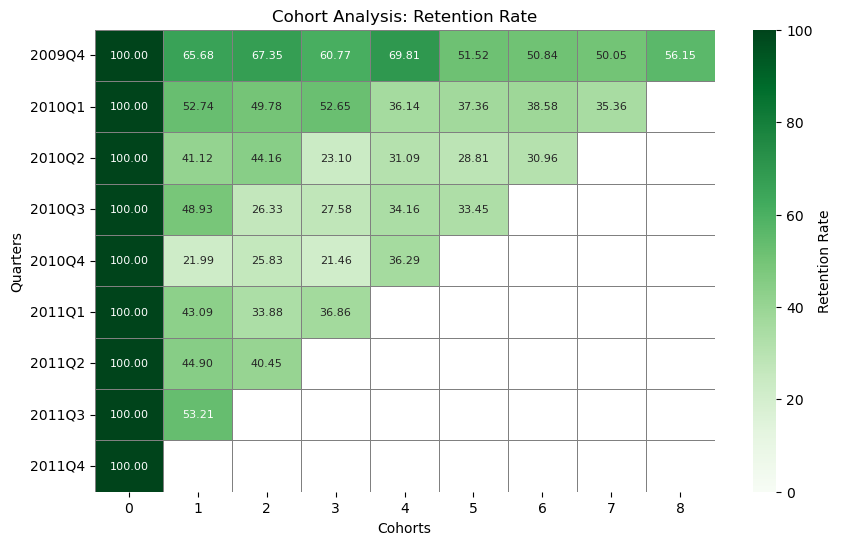

In [358]:
plt.figure(figsize=(10,6))

heatmap = sns.heatmap(
    data=cohorts_pivot,
    annot=True,                # 셀 내부에 값 표시
    annot_kws={"size": 8}, 
    fmt='.2f',                 # 텍스트 형식 (소수점 2자리)
    cmap='Greens',             # 색상 팔레트
    cbar_kws={'label': 'Retention Rate'},  # 컬러바 제목
    linewidths=0.5,            # 셀 간격
    linecolor='gray',          # 셀 경계 색상
    vmin=0, vmax=100           # Retention Rate의 범위 설정
)

plt.title('Cohort Analysis: Retention Rate')
plt.xlabel('Cohorts')
plt.ylabel('Quarters')
plt.show() 


# 그래프 추가 정리 LATER (ex. Quarter 표시 방식)

### 문제 7. Retention: 코호트 분석(평균 구매수량)

- 분기단위의 활성 사용자의 평균 구매수량을 분석
    - 구매수량이기 때문에 0 index의 값이 100% 가 아닌 절대 값임을 주의

In [318]:
dfa.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,FirstPurchase,is_activated,current_q,cohort_q,quarter_diff
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12-01 07:45:00,True,2009Q4,2009Q4,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01 07:45:00,True,2009Q4,2009Q4,0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01 07:45:00,True,2009Q4,2009Q4,0


In [319]:
dfa['avg_quantity'] = dfa.groupby('Customer ID')['Quantity'].transform('mean').round(1)
dfa.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,FirstPurchase,is_activated,current_q,cohort_q,quarter_diff,avg_quantity
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12-01 07:45:00,True,2009Q4,2009Q4,0,9.1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01 07:45:00,True,2009Q4,2009Q4,0,9.1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01 07:45:00,True,2009Q4,2009Q4,0,9.1


In [320]:
cohort_quant = dfa.groupby(['cohort_q', 'quarter_diff'])['avg_quantity'].mean()
cohort_quant_df = cohort_quant.to_frame().sort_values(by=['cohort_q']).round(1)
# cohort_quant_df = cohort_quant.to_frame().rename(columns = {'Customer ID' : 'customers'}).sort_values(by=['cohort_q']).round(1)
cohort_quant_df

avg_quantity
cohort_q quarter_diff              
2009Q4   0                     12.9
         1                     20.0
         2                     14.4
         3                     15.0
         4                     13.3
         5                     16.3
         6                     16.2
         7                     16.7
         8                     14.1
2010Q1   7                      9.8
         6                     12.6
         5                     11.3
         4                     11.1
         0                     10.5
         2                     11.3
         1                     13.0
         3                     10.0
2010Q2   4                     14.8
         6                     10.0
         3                     15.0
         5                     15.4
         1                     11.4
         0                     11.2
         2                      9.6
2010Q3   0                     14.2
         1                      9.1
         2                     11.2
         3                     10.3
         4                     12.7
         5                     10.4
2010Q4   4                      8.4
         3                      9.1
         2                      8.4
         0                      8.1
         1                      8.9
2011Q1   0                     10.3
         1                     15.1
         2                     12.3
         3                      9.8
2011Q2   0                      9.4
         1                     10.8
         2                      8.8
2011Q3   1                      6.2
         0                      9.3
2011Q4   0                      8.7

In [321]:
cohorts_quant_pivot = cohort_quant_df.pivot_table(index='cohort_q', columns = 'quarter_diff', values = 'avg_quantity')
cohorts_quant_pivot 

quarter_diff,0,1,2,3,4,5,6,7,8
cohort_q,,,,,,,,,
2009Q4,12.9,20.0,14.4,15.0,13.3,16.3,16.2,16.7,14.1
2010Q1,10.5,13.0,11.3,10.0,11.1,11.3,12.6,9.8,NaN
2010Q2,11.2,11.4,9.6,15.0,14.8,15.4,10.0,NaN,NaN
2010Q3,14.2,9.1,11.2,10.3,12.7,10.4,NaN,NaN,NaN
2010Q4,8.1,8.9,8.4,9.1,8.4,NaN,NaN,NaN,NaN
2011Q1,10.3,15.1,12.3,9.8,NaN,NaN,NaN,NaN,NaN
2011Q2,9.4,10.8,8.8,NaN,NaN,NaN,NaN,NaN,NaN
2011Q3,9.3,6.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011Q4,8.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


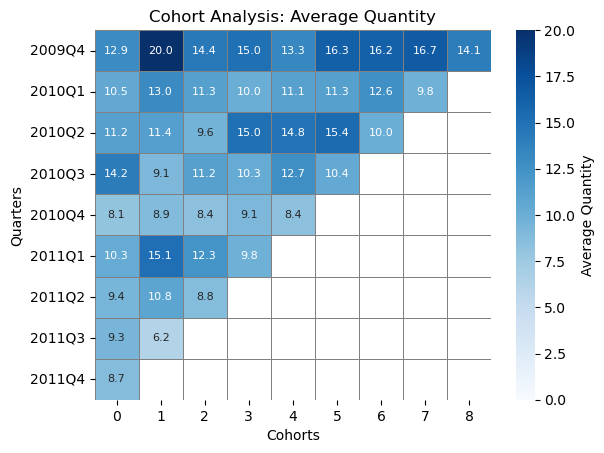

In [359]:
heatmap = sns.heatmap(
    data=cohorts_quant_pivot ,
    annot=True,                # 셀 내부에 값 표시
    annot_kws={"size": 8}, 
    fmt='.1f',                 # 텍스트 형식 (소수점 1자리)
    cmap='Blues',              # 색상 팔레트
    cbar_kws={'label': 'Average Quantity'},  # 컬러바 제목
    linewidths=0.5,            # 셀 간격
    linecolor='gray',          # 셀 경계 색상
    vmin=0                     # 최소값 설정 (필요 시 조정 가능)
)

plt.title('Cohort Analysis: Average Quantity')
plt.xlabel('Cohorts')
plt.ylabel('Quarters')
plt.show() 

# 그래프 추가 정리 LATER

### 문제 8. Revenue : ARPU

- 각 고객의 월별 구매 금액을 집계하고, 이를 기반으로 ARPU를 분석

In [323]:
df.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,FirstPurchase,is_activated
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12-01 07:45:00,True
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01 07:45:00,True
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01 07:45:00,True


In [324]:
df['purchase_month'] = df['InvoiceDate'].dt.to_period('M')

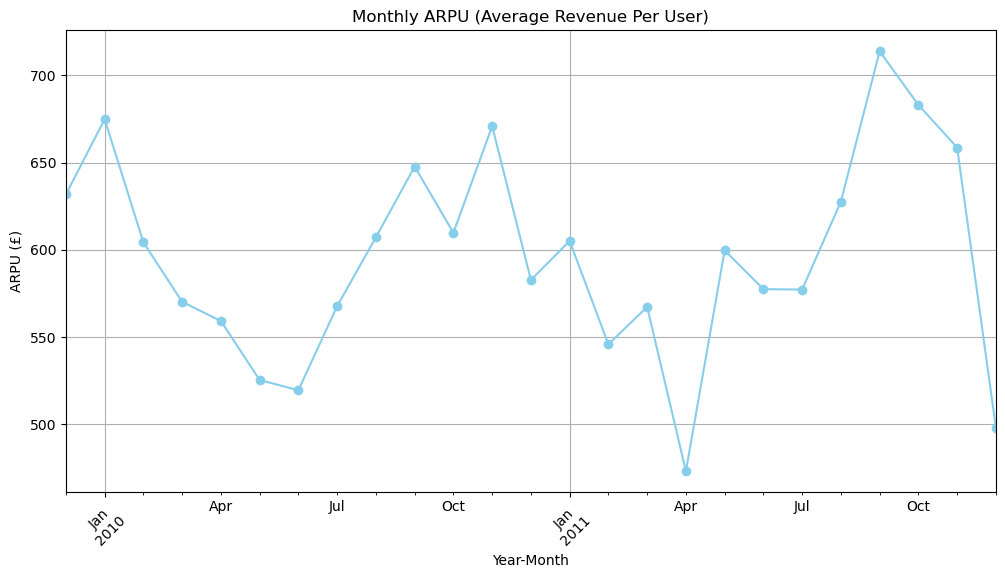

In [325]:
monthly_revenue = df.groupby('purchase_month')['Total'].sum()
monthly_users = df.groupby('purchase_month')['Customer ID'].nunique()
monthly_arpu = monthly_revenue / monthly_users

#시각화코드
plt.figure(figsize=(12, 6))
monthly_arpu.plot(kind='line', marker='o', color='skyblue')
plt.title("Monthly ARPU (Average Revenue Per User)")
plt.xlabel("Year-Month")
plt.ylabel("ARPU (£)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 문제 9. Revenue(CLV)

- 고객 생애 가치를 예측하기 위해 **CLV**를 계산하고 표로 CLV기준으로 내림차순으로 정렬
- **CLV 식: 평균금액 x  평균 구매 빈도 x 고객유지기간**(단, Invoce Date의 최대 최소를 빼준 뒤 1을 더해주기)

In [326]:
df.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,FirstPurchase,is_activated,purchase_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12-01 07:45:00,True,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01 07:45:00,True,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01 07:45:00,True,2009-12


In [327]:
customer_data = df.groupby('Customer ID').agg({
    'Invoice': 'nunique',        # 구매 횟수
    'Total': 'sum',           # 총 지출 금액
    'InvoiceDate': ['min', 'max']  # 첫 구매일과 마지막 구매일
}).reset_index()
customer_data.columns = ['Customer ID', 'PurchaseFrequency', 'TotalRevenue', 'FirstPurchaseDate', 'LastPurchaseDate']
customer_data.head(3)

,Customer ID,PurchaseFrequency,TotalRevenue,FirstPurchaseDate,LastPurchaseDate
0,12346.0,17,-51.74,2009-12-14 08:34:00,2011-01-18 10:17:00
1,12347.0,8,4921.53,2010-10-31 14:20:00,2011-12-07 15:52:00
2,12348.0,5,2019.40,2010-09-27 14:59:00,2011-09-25 13:13:00


In [328]:
customer_data['CustomerLifetime'] = ((customer_data['LastPurchaseDate'] - customer_data['FirstPurchaseDate']).dt.days) + 1

In [329]:
customer_data['AverageOrderValue'] = customer_data['TotalRevenue'] / customer_data['PurchaseFrequency']

In [330]:
customer_data['CLV'] = customer_data['AverageOrderValue'] * customer_data['PurchaseFrequency'] * (customer_data['CustomerLifetime'] / 365)

In [336]:
customer_data.sort_values('CLV', ascending = False).round(2)

# PurchaseFrequency가 평균 빈도 이려면 전체 구매 건수가 아닌, 연간 평균 구매 횟수로 변경되어야 하지 않을까? check LATER
# 표의 컬럼명 등을 예시결과와 동일하게 변경해야하는 것일까? check LATER

,Customer ID,PurchaseFrequency,TotalRevenue,FirstPurchaseDate,LastPurchaseDate,CustomerLifetime,AverageOrderValue,CLV
5756,18102.0,153,570380.61,2009-12-01 09:24:00,2011-12-09 11:50:00,739,3727.98,1154825.40
2300,14646.0,164,523342.07,2009-12-02 16:52:00,2011-12-08 12:12:00,736,3191.11,1055287.02
1810,14156.0,202,296063.44,2009-12-01 12:30:00,2011-11-30 10:54:00,729,1465.66,591315.75
2565,14911.0,510,265757.91,2009-12-01 11:41:00,2011-12-08 15:54:00,738,521.09,537340.65
1348,13694.0,164,190020.84,2009-12-04 15:26:00,2011-12-06 09:32:00,732,1158.66,381082.89
...,...,...,...,...,...,...,...,...
5053,17399.0,1,-25111.09,2010-06-17 16:52:00,2010-06-17 16:52:00,1,-25111.09,-68.80
1430,13776.0,8,-340.17,2010-01-26 16:51:00,2010-10-07 16:59:00,255,-42.52,-237.65
745,13091.0,6,-130.22,2009-12-08 12:25:00,2011-11-18 16:48:00,711,-21.70,-253.66
3067,15413.0,7,-2531.38,2009-12-01 10:18:00,2010-10-05 15:15:00,309,-361.63,-2143.00


### 기초 통계 문제

문제 10. 어떤 회사의 고객 대기시간은 5분에서 15분 사이의 균등분포를 따릅니다. 고객 100명이 대기한 시간을 시뮬레이션하고, 평균 대기시간과 표준편차를 계산하세요.

In [332]:
from scipy.stats import uniform


waiting_times = uniform.rvs(size=100, loc=5, scale=15, random_state=0)
print(f'평균 대기 시간: {np.mean(waiting_times).round(2)}')
print(f'표준 편차: {np.std(waiting_times, ddof=1).round(2)}')

평균 대기 시간: 12.09
표준 편차: 4.35


문제 11. 한 신제품의 초기 성공 확률이 0.3이라고 가정합니다. 10회의 시뮬레이션에서 성공한 횟수를 구하고, 각 성공 여부를 출력하세요.

In [333]:
from scipy.stats import bernoulli

p = 0.3
n = 10

outcomes = bernoulli.rvs(p, size=n)
success_count = outcomes.sum()

print(f"성공 횟수: {success_count}")
print(f"각 성공 여부: {outcomes}")

성공 횟수: 4
각 성공 여부: [0 0 1 1 1 0 0 0 0 1]


문제 13. 한 공장에서 생산되는 제품의 무게는 평균 50g, 표준편차 5g의 정규분포를 따릅니다.  
1000개의 제품 무게를 시뮬레이션하고, 무게가 45g 이상 55g 이하인 제품의 비율을 계산(변수명: within_range)하세요. 무게 분포의 히스토그램을 그리세요. 

In [334]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mu = 50
sigma = 5
num_of_samples = 1000

weights = norm.rvs(loc=mu, scale=sigma, size=num_of_samples, random_state=0)

conds = (weights >= 45) & (weights <=55)

within_range = len(weights[conds]) / len(weights)
print(f'45g 이상 55g 이하 비율: {within_range:.2f}')

45g 이상 55g 이하 비율: 0.70


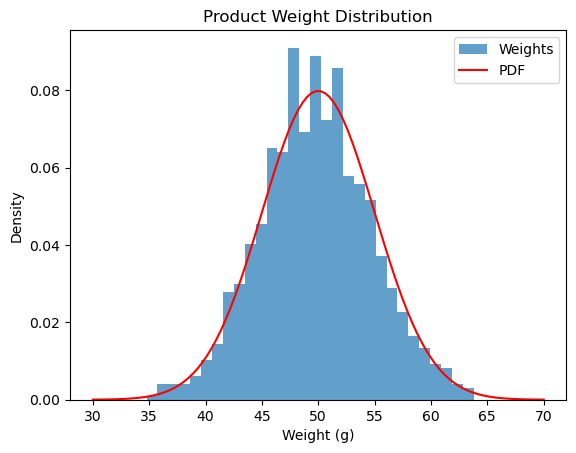

45g 이상 55g 이하 비율: 69.90%


In [335]:
plt.hist(weights, bins=30, density=True, alpha=0.7, label="Weights")
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', label="PDF")
plt.xlabel("Weight (g)")
plt.ylabel("Density")
plt.title("Product Weight Distribution")
plt.legend()
plt.show()

print(f"45g 이상 55g 이하 비율: {within_range:.2%}")

### KPT

- 잘한 점(Keep):   
  - gpt에 의존하지 않으려고 최대한 노력하였다. 대신 해결이 안되는 문제에 대해서는 구글링의 도움을 받았다.    
  gpt에 물어서 쉽게 답을 구하는 것보다, 시간이 더 소요되더라도 구글링을 하면 다양한 방법을 시도해볼 수 있다는 점에서 현 시점의 나에게는 더 적절하다는 생각이 든다. (물론 혼자서 해결하면 더 좋겠지만..!)
  - 그래프를 예시와 동일하게 만들려고 방법을 찾다가, 한 사이클을 모두 완료한 후에 다시 돌아가야겠다고 마음먹고 'LATER'라고 표시를 해두었다.    
  LATER 총 6건, 추가로 정리해봐야겠다. (시간 내 LATER들도 해결했다면 더 좋았겠지만..!) 
- 아쉬운 점(Problem): 데이터를 심도 있게 관찰하고, 나만의 아이디어를 토대로 분석하려는 노력이 부족했다.    
캐글 데이터를 통해 혼자서 분석해보는 연습을 해서 자체적인 분석력, 데이터 해석력을 늘려야겠다.
- 개선할 점(Try): 
  - '활성 사용자'에 대해 고민해봤지만 당장 결과를 도출하기에 급급해서 dfa에 df를 복사하여 활성화 안 된 사용자 행을 제거하여 Cohort Analysis를 진행했다. (이후 ARPU, CLV 분석에는 df를 사용했다.) 실제 데이터 분석을 위해서는 이런 방식이 옳은 것일까? 결측/중복이 아닌 데이터를 제거하여 분석을 진행하는 것에는 문제가 있어보인다. 개선 방안을 알고 싶고, 다른 그루분들과도 논의해봐야겠다.
  - CLV 분석에 있어 통계 교육 Day2의 실습을 참고하여 진행해보니, Frequency가 해당 고객의 전체 구매 횟수인데, 문제에는 '평균 구매 빈도'라고 서술되어 있엇다. 이 또한 전체 문제를 진행하기 위해 고민을 멈추고 배운 방법만 활용하여 퀘스트를 진행했다. 결과에 차이가 있는 것일지 확인해봐야겠다. 
  - 다양한 고민과 의문점이 들었지만 퀘스트 중에 논의가 부족했다는 점 또한 개선할 부분이다. 시간에 쫓기는 마음과, 잘 모르는 것에 대한 두려움을 잘 다스리고 의논에 참여해야겠다. 

